In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yeshithabhuvanesh","key":"7f125a427b722fea97b168beba37603f"}'}

In [3]:
# Get the download URL from Kaggle and use wget
# First, get your Kaggle credentials
import json

with open('/content/kaggle.json', 'r') as f:
    creds = json.load(f)
    username = creds['username']
    key = creds['key']

# Download using curl with retry
!curl -L -o ubfc-2.zip \
  --retry 10 \
  --retry-delay 5 \
  -u {username}:{key} \
  "https://www.kaggle.com/api/v1/datasets/download/ashfakyeafi/ubfc-2"

# Unzip
!unzip -q ubfc-2.zip -d ubfc-dataset
print("Done!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12.0G  100 12.0G    0     0  22.6M      0  0:09:05  0:09:05 --:--:-- 23.4M
Done!


Device: cuda

LOADING DATASET

Found 16 subjects

subject10: 88.4 BPM
subject11: 93.2 BPM
subject12: 67.7 BPM
subject13: 88.9 BPM
subject14: 75.9 BPM
subject15: 88.6 BPM
subject16: 78.7 BPM
subject17: 78.1 BPM
subject18: 96.2 BPM
subject20: 92.7 BPM
subject22: 89.6 BPM
subject3: 77.0 BPM
subject4: 87.9 BPM
subject5: 81.9 BPM
subject8: 91.6 BPM
subject9: 85.5 BPM

Total: 16 videos
BPM Range: 68 - 96

SPLITTING DATA

Train: 11 | Val: 2 | Test: 3

MODEL

Parameters: 26,465 (ultra-light!)

TRAINING


Epoch   1: Loss=7233.37 | Val MAE= 90.0 BPM | RMSE= 90.0
           New best!


Epoch   5: Loss=6147.22 | Val MAE= 80.0 BPM | RMSE= 80.0
           New best!


Epoch  10: Loss=493.22 | Val MAE= 14.5 BPM | RMSE= 14.7


Epoch  15: Loss=355.31 | Val MAE=  9.9 BPM | RMSE= 10.3


Epoch  20: Loss=439.47 | Val MAE= 13.0 BPM | RMSE= 13.2



Early stop at epoch 21

TEST RESULTS

 Performance:
  MAE:  2.3 BPM
  RMSE: 2.4 BPM
  ± 5 BPM: 100.0%
  ±10 BPM: 100.0%
  ±15 BPM: 100.0%
  ±20 BPM: 100.0%

  Average Stress Score: 62.8/100

 Sample Predictions with Stress Analysis:
  True=  93.2 → Pred=  90.6 (Error=  2.6)
  Stress: 73/100 - HIGH (Stressed)
  True=  81.9 → Pred=  84.4 (Error=  2.6)
  Stress: 57/100 - MODERATE
  True=  88.6 → Pred=  86.8 (Error=  1.8)
  Stress: 59/100 - MODERATE

 Saved to 'results.png'

 DONE! Best MAE: 2.9 BPM


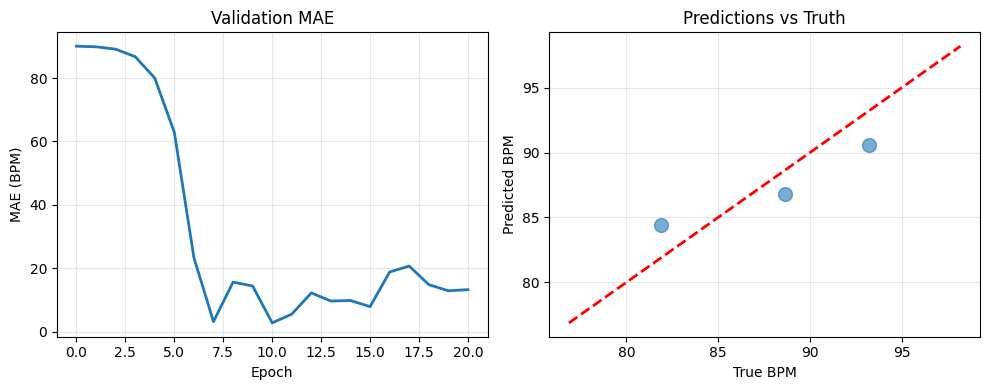

In [5]:
# Ultra-Light rPPG Model: Simple CNN Network

import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION
class Config:
    DATASET_PATH = '/content/ubfc-dataset'

    # Much smaller for CPU
    IMG_SIZE = 36  # Very small images
    FRAME_DEPTH = 180  # Only 6 second of video
    FPS = 30

    # Training
    BATCH_SIZE = 2
    EPOCHS = 100  # Fewer epochs
    LEARNING_RATE = 1e-3  # Higher learning rate

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LOAD GROUND TRUTH
def load_ground_truth_txt(gt_file):
    """Load ground truth from txt file"""
    try:
        hr_values = []
        with open(gt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue

                parts = line.replace(',', ' ').split()
                try:
                    hr = float(parts[-1])
                    if 40 <= hr <= 200:
                        hr_values.append(hr)
                except:
                    continue

        return np.mean(hr_values) if hr_values else None
    except:
        return None

def explore_dataset(dataset_path):
    """Load dataset"""
    print("\n" + "="*60)
    print("LOADING DATASET")
    print("="*60)

    video_data = []
    subject_folders = sorted([
        d for d in glob.glob(os.path.join(dataset_path, '*'))
        if os.path.isdir(d) and 'subject' in os.path.basename(d).lower()
    ])

    print(f"\nFound {len(subject_folders)} subjects\n")

    for subject_folder in subject_folders:
        subject_name = os.path.basename(subject_folder)

        video_files = []
        for pattern in ['vid.avi', '*.avi', '*.mp4']:
            video_files.extend(glob.glob(os.path.join(subject_folder, pattern)))

        gt_files = glob.glob(os.path.join(subject_folder, 'ground_truth.txt'))
        if not gt_files:
            gt_files = glob.glob(os.path.join(subject_folder, 'gt*.txt'))

        if video_files and gt_files:
            gt_bpm = load_ground_truth_txt(gt_files[0])

            if gt_bpm:
                video_data.append({
                    'path': video_files[0],
                    'subject': subject_name,
                    'bpm': gt_bpm
                })
                print(f"{subject_name}: {gt_bpm:.1f} BPM")

    print(f"\n{'='*60}")
    print(f"Total: {len(video_data)} videos")

    if video_data:
        bpms = [v['bpm'] for v in video_data]
        print(f"BPM Range: {np.min(bpms):.0f} - {np.max(bpms):.0f}")

    return video_data

# DATASET
class FastDataset(Dataset):
    def __init__(self, video_data, config):
        self.video_data = video_data
        self.config = config

    def __len__(self):
        return len(self.video_data)

    def __getitem__(self, idx):
        data = self.video_data[idx]
        frames = self.load_video(data['path'])

        if frames is None:
            frames = torch.zeros(self.config.FRAME_DEPTH, 3, self.config.IMG_SIZE, self.config.IMG_SIZE)
            bpm = 80.0
        else:
            bpm = data['bpm']

        return frames, torch.tensor(bpm, dtype=torch.float32)

    def load_video(self, video_path):
        """Load video FAST - no face detection"""
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                return None

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames < self.config.FRAME_DEPTH:
                cap.release()
                return None

            # Sample frames
            indices = np.linspace(0, total_frames - 1, self.config.FRAME_DEPTH, dtype=int)

            frames = []
            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    break

                # Just crop center (skip face detection for speed)
                h, w = frame.shape[:2]
                size = min(h, w)
                y = (h - size) // 2
                x = (w - size) // 2
                frame = frame[y:y+size, x:x+size]

                # Resize small
                frame = cv2.resize(frame, (self.config.IMG_SIZE, self.config.IMG_SIZE))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = frame.astype(np.float32) / 255.0
                frames.append(frame)

            cap.release()

            if len(frames) != self.config.FRAME_DEPTH:
                return None

            frames = np.array(frames)
            frames = torch.from_numpy(frames).permute(0, 3, 1, 2).float()

            return frames
        except:
            return None

# ULTRA-SIMPLE MODEL
class UltraLightNet(nn.Module):
    """
    Extremely simple model - just enough to learn BPM
    Only ~20K parameters!
    """
    def __init__(self):
        super(UltraLightNet, self).__init__()

        # Very simple feature extractor
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2, padding=2),  # 36 -> 18
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 18 -> 9

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3),  # 9 -> 3
        )

        # Simple temporal processing
        self.fc = nn.Sequential(
            nn.Linear(32 * 3 * 3, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x: [B, T, C, H, W]
        B, T, C, H, W = x.shape

        # Process all frames
        x = x.reshape(B * T, C, H, W) # Changed from .view to .reshape
        x = self.conv(x)
        x = x.reshape(B, T, -1) # Changed from .view to .reshape

        # Average across time
        x = x.mean(dim=1)

        # Predict BPM
        bpm = self.fc(x)
        return bpm.squeeze()

# STRESS SCORE CALCULATION
def calculate_stress_score(bpm, prediction_error=0):
    """
    Calculate stress score (0-100) based on BPM

    Stress Zones (research-based):
    - Resting: 60-80 BPM → Low stress
    - Elevated: 80-100 BPM → Moderate stress
    - High: 100+ BPM → High stress

    Also considers prediction confidence
    """
    # Component 1: Heart Rate Stress (main indicator)
    # Based on deviation from resting HR (60-80 BPM)
    if bpm < 60:
        # Very low HR (could indicate relaxation or bradycardia)
        hr_stress = 0.2
    elif bpm <= 80:
        # Normal resting range
        hr_stress = (bpm - 60) / 60  # 0.0 to 0.33
    elif bpm <= 100:
        # Elevated HR
        hr_stress = 0.33 + (bpm - 80) / 40  # 0.33 to 0.83
    else:
        # High HR (stress, exercise, or anxiety)
        hr_stress = 0.83 + min((bpm - 100) / 100, 0.17)  # 0.83 to 1.0

    # Component 2: Prediction Confidence
    # Lower error = more confident = more reliable stress score
    confidence_penalty = min(prediction_error / 20, 0.15)  # Max 15% penalty

    # Combined stress score (0-100)
    stress_score = (hr_stress + confidence_penalty) * 100

    return np.clip(stress_score, 0, 100)

# TRAINING
def train_epoch(model, dataloader, optimizer, config):
    model.train()
    total_loss = 0

    for videos, bpm_labels in tqdm(dataloader, desc="Training", leave=False):
        videos = videos.to(config.DEVICE)
        bpm_labels = bpm_labels.to(config.DEVICE)

        optimizer.zero_grad()

        pred_bpm = model(videos)
        loss = nn.functional.mse_loss(pred_bpm, bpm_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, config):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for videos, bpm_labels in dataloader:
            videos = videos.to(config.DEVICE)

            pred_bpm = model(videos)

            pred_np = pred_bpm.cpu().numpy()
            label_np = bpm_labels.numpy()

            if pred_np.ndim == 0:
                pred_np = np.array([pred_np])
            if label_np.ndim == 0:
                label_np = np.array([label_np])

            predictions.extend(pred_np)
            targets.extend(label_np)

    predictions = np.array(predictions)
    targets = np.array(targets)

    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(np.mean((predictions - targets) ** 2))

    return mae, rmse, predictions, targets

# MAIN
def main():
    config = Config()
    print(f"Device: {config.DEVICE}")
    if config.DEVICE.type == 'cpu':
        print("Running on CPU - using ultra-light model")

    # Load data
    video_data = explore_dataset(config.DATASET_PATH)

    if len(video_data) < 3:
        print("\nNeed at least 3 videos!")
        return

    # Split
    print("\n" + "="*60)
    print("SPLITTING DATA")
    print("="*60)

    train_data, temp_data = train_test_split(video_data, test_size=0.3, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    print(f"\nTrain: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

    # Create datasets
    train_dataset = FastDataset(train_data, config)
    val_dataset = FastDataset(val_data, config)
    test_dataset = FastDataset(test_data, config)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    # Model
    print("\n" + "="*60)
    print("MODEL")
    print("="*60)

    model = UltraLightNet().to(config.DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

    params = sum(p.numel() for p in model.parameters())
    print(f"\nParameters: {params:,} (ultra-light!)")

    # Training
    print("\n" + "="*60)
    print("TRAINING")
    print("="*60)

    best_mae = float('inf')
    patience = 10
    patience_counter = 0
    history = {'train_loss': [], 'val_mae': []}

    for epoch in range(config.EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, config)
        val_mae, val_rmse, _, _ = validate_epoch(model, val_loader, config)

        history['train_loss'].append(train_loss)
        history['val_mae'].append(val_mae)

        # Print every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Loss={train_loss:6.2f} | Val MAE={val_mae:5.1f} BPM | RMSE={val_rmse:5.1f}")

        if val_mae < best_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"           New best!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stop at epoch {epoch+1}")
                break

    # Test
    print("\n" + "="*60)
    print("TEST RESULTS")
    print("="*60)

    model.load_state_dict(torch.load('best_model.pth'))
    test_mae, test_rmse, predictions, targets = validate_epoch(model, test_loader, config)

    print(f"\n Performance:")
    print(f"  MAE:  {test_mae:.1f} BPM")
    print(f"  RMSE: {test_rmse:.1f} BPM")

    for thresh in [5, 10, 15, 20]:
        acc = np.mean(np.abs(predictions - targets) <= thresh) * 100
        print(f"  ±{thresh:2d} BPM: {acc:5.1f}%")

    # Calculate overall stress distribution
    stress_scores = [calculate_stress_score(pred, abs(pred - true))
                     for pred, true in zip(predictions, targets)]
    avg_stress = np.mean(stress_scores)
    print(f"\n  Average Stress Score: {avg_stress:.1f}/100")

    # Show predictions with stress scores
    print(f"\n Sample Predictions with Stress Analysis:")
    for i, (pred, true) in enumerate(zip(predictions, targets)):
        error = abs(pred - true)

        # Calculate stress score
        stress_score = calculate_stress_score(pred, error)

        if stress_score < 30:
            stress_level = "LOW (Relaxed)"
        elif stress_score < 60:
            stress_level = "MODERATE"
        else:
            stress_level = "HIGH (Stressed)"

        print(f"  True={true:6.1f} → Pred={pred:6.1f} (Error={error:5.1f})")
        print(f"  Stress: {stress_score:.0f}/100 - {stress_level}")

    # Quick plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['val_mae'], linewidth=2)
    plt.title('Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE (BPM)')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(targets, predictions, s=100, alpha=0.6)
    plt.plot([min(targets)-5, max(targets)+5], [min(targets)-5, max(targets)+5], 'r--', linewidth=2)
    plt.title('Predictions vs Truth')
    plt.xlabel('True BPM')
    plt.ylabel('Predicted BPM')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results.png', dpi=100)
    print("\n Saved to 'results.png'")

    print("\n" + "="*60)
    print(f" DONE! Best MAE: {best_mae:.1f} BPM")
    print("="*60)

if __name__ == "__main__":
    main()
